# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, SequentialEvaluator, MultiprocessingEvaluator)


from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel
from ema_workbench.connectors.netlogo import NetLogoModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\ProgramData\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
# Defining models and solving

# Python

model_python = Model('PredPreyPython', function=PredPrey)

model_python.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                       RealParameter('predator_efficiency', 0.001, 0.004),
                       RealParameter('predator_loss_rate', 0.04, 0.08)]

model_python.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

# Excel
model_excel = ExcelModel('PredPreyExcel',
                         wd="./model/",
                         model_file="PredPrey.xlsx")

model_excel.uncertainties = model_python.uncertainties

model_excel.outcomes  = model_python.outcomes

# name of the sheet
model_excel.default_sheet = "Sheet1"

#Netlogo

ema_logging.log_to_stderr(ema_logging.INFO)

model_netlogo = NetLogoModel('PredPreyNetlogo',
                         wd="./model/",
                         model_file="PredPrey.nlogo")
model_netlogo.run_length = 1460
model_netlogo.replications = 1

model_netlogo.uncertainties = model_python.uncertainties

model_netlogo.outcomes = model_python.outcomes

''' Model did not work in our case

# Vensim
from ema_workbench.connectors.vensim import VensimModel

wd = './model'
model_vensim = VensimModel('PredPrey',
                         wd="./model",
                         model_file="PredPrey.vpmx")
    
model_vensim.uncertainties = model_python.uncertainties

model_vensim.outcomes = model_python.outcomes

with SequentialEvaluator(model_vensim) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=50)
'''
    
n=1

with SequentialEvaluator([model_python, model_excel, model_netlogo]) as evaluator:
    experimentsp, outcomesp = evaluator.perform_experiments(scenarios=50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 3 model(s) = 150 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 15 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 45 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 75 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 105 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 135 cases completed
[MainProcess/INFO] 150 cases completed
[MainProcess/INFO] experiments finished


(<Figure size 432x288 with 2 Axes>,
 {'predators': <AxesSubplot:xlabel='Time', ylabel='predators'>,
  'prey': <AxesSubplot:xlabel='Time', ylabel='prey'>})

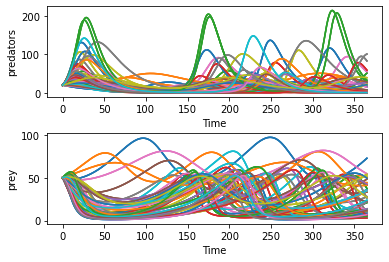

In [3]:
# Plotting results

from ema_workbench.analysis import plotting, lines

for scenario in outcomesp:
    outcomesp[scenario] = np.squeeze(outcomesp[scenario])

plotting.lines(experimentsp, outcomesp, titles={''})

In [4]:
import pandas as pd
pd.set_option('display.max_rows', None)
experimentsp

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.001469,0.001111,0.077022,0.023133,0,None,PredPreyPython
1,0.001840,0.001943,0.046096,0.030975,1,None,PredPreyPython
2,0.002471,0.002727,0.063995,0.018884,2,None,PredPreyPython
3,0.002816,0.003136,0.079752,0.018032,3,None,PredPreyPython
4,0.002690,0.002370,0.044677,0.019081,4,None,PredPreyPython
5,0.001909,0.002093,0.053786,0.023542,5,None,PredPreyPython
6,0.001026,0.002291,0.056547,0.034900,6,None,PredPreyPython
7,0.001283,0.003848,0.076313,0.026852,7,None,PredPreyPython
8,0.001105,0.003980,0.062709,0.018252,8,None,PredPreyPython
9,0.002925,0.001852,0.069429,0.015406,9,None,PredPreyPython


In [5]:
# extracting values from dict 
keys_to_extract = ["prey"]
prey_subset = {key: outcomesp[key] for key in keys_to_extract}

keys, prey_values = zip(*prey_subset.items())

In [6]:
# defining prey values by model and converting to array from tuple

python_prey = prey_values[0][0:50]
python_prey = np.ndarray.flatten(python_prey)

excel_prey = prey_values[0][50:100]
excel_prey = np.ndarray.flatten(excel_prey)

netlogo_prey = prey_values[0][100:150]
netlogo_prey = np.ndarray.flatten(netlogo_prey)

In [7]:
# maximum absolute error of the time series

from sklearn.metrics import max_error

max_error_excel = max_error(python_prey, excel_prey)
max_error_netlogo = max_error(python_prey, netlogo_prey)

print('Max error excel : ', max_error_excel, ', Max error netlogo : ',max_error_netlogo)

Max error excel :  2.842170943040401e-14 , Max error netlogo :  7.887024366937112e-13
